# Enrichment analysis of CNVs in schizophrenia

## Steps
1. Load CNV data and reference gene database, and drop identical CNVs and genes.
  * **FIXME**: boundary of genes are yet to be polished
2. Count the number of CNVs overlapping with each gene.
3. Perform Fisher Exact tests for each gene which is overlapped with CNVs in deletion and duplication.
4. Draw barplots for deletion and duplication.

In [1]:
import pandas as pd
from pandasql import sqldf
from fisher import pvalue
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
# for the plot to be showed in Jupyter notebook
%matplotlib inline

## Load CNV and drop duplicates
CNV file in `bed` format is downloaded from [http://pngu.mgh.harvard.edu/isc/isc-r1.cnv.bed](http://pngu.mgh.harvard.edu/isc/isc-r1.cnv.bed). It includes four separate datasets, deletion cases, deletion controls, duplication cases and duplication controls. The sample sizes for the four datasets are 1374, 1278, 2228 and 1873, respectively. Every line in each dataset represents a CNV (chromosome, start and end position). Similar start and end positions exit. Some of them are only different by hundreds to thousands of SNPs.

Import `CNV.bed` file first, divide into four datasets. Each dataset includes 22 chromosome and CNV start/end positions on each chromosome. Then, sort start/end position by ascending order. The CNV.bed file does not include sex chromosome.

In [2]:
filename = "data/ISC-r1.CNV.bed"
cnvbed = {}
dataset = None
for line in open(filename).readlines():
    if not line.startswith("chr"):
        dataset = line.strip().split()[1].lstrip("name=")
        cnvbed[dataset] = {}
        continue
    line = line.strip().split()
    if not line[0] in cnvbed[dataset]:
        cnvbed[dataset][line[0]] = []
    cnvbed[dataset][line[0]].append((int(line[1]),int(line[2])))
    
for dataset in cnvbed.keys():
    for chrom in cnvbed[dataset]:
        cnvbed[dataset][chrom].sort()

Use `pandas` to transfer dictionaries from last step to a `DataFrame`, which contains four parts, cases and controls for deletion and duplication, then drop cuplicates if CNVs share identical chromosome, start and end position.

In [3]:
cnvbed_df = {}
for dataset in cnvbed.keys():
    cnvbed_df[dataset] = {"chrom":[], "cnv_start":[], "cnv_end":[]}
    for chrom in cnvbed[dataset]:
        start, end = tuple(zip(*cnvbed[dataset][chrom]))
        cnvbed_df[dataset]["chrom"].extend([chrom] * len(start))
        cnvbed_df[dataset]["cnv_start"] += list(start)
        cnvbed_df[dataset]["cnv_end"] += list(end)
    cnvbed_df[dataset] = pd.DataFrame.from_dict(cnvbed_df[dataset]).drop_duplicates(
                                            subset=("chrom", "cnv_start", "cnv_end"))
#print (cnvbed_df)

## Load reference gene database and drop duplicates
The database for reference gene can be downloaded from [http://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/refGene.txt.gz](http://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/refGene.txt.gz). The meta information is described here [http://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/refGene.sql](http://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/refGene.sql).

Import reference transcripts and their chromosome, start and end position as a table using pandas.

Use sqldf to query DataFrame. Combine gene by dropping duplicates if they share identical chromosome, start and end position.

In [4]:
ref_gene = pd.read_table("data/refGene.txt.gz", compression="gzip", sep="\t", 
                         header = None, usecols=(1,2,4,5,12), 
                         names = ["tx_name", "chrom", "tx_start", "tx_end", "gene_name"])

gene_df = ref_gene.drop_duplicates(subset=("chrom", "tx_start", "tx_end"))
#gene_df = gene_df.rename(columns={"tx_start": "gene_start", "tx_end": "gene_end"})
print (gene_df[:10])

         tx_name  chrom   tx_start     tx_end     gene_name
0      NR_046018   chr1      11873      14409       DDX11L1
1      NR_024540   chr1      14361      29370        WASH7P
2      NR_033380   chrX    2527305    2575270        CD99P1
3      NR_033381   chrY    2477305    2506370        CD99P1
4      NM_201627   chr5  180650262  180662808        TRIM41
5      NM_182559  chr12   51236700   51281663      TMPRSS12
6      NR_039983   chr1     134772     140566     LOC729737
7      NR_028322   chr1     323891     328581  LOC100132287
10  NM_001130980   chr2   71680752   71913893          DYSF
11  NM_001135686  chr19   54573200   54584634         TARM1


## Calculate number of CNVs per gene
Figure out the number of CNVs overlapped in each gene according to their start/end positions.
* If the start and/or end postion for a CNV locate between a gene, it is said that CNV and gene overlap. Each line represents a CNV. However, same CNV may overlap with more than one gene, and one gene may contain more than one CNV.

|   |  chr |  start |  end |  gene |
|---|---|---|---|---|
|1|     chr11|    1774671 |   1945240 |         CTSD|
|2|     chr11|    1774671 |   1945240 |        TNNT3|
|3|     chr11|    4077830 |   4264576 |        STIM1|
|4|     chr11|    4077830 |   4303386 |        STIM1|
|5|     chr11|    4081373 |   4232710 |        STIM1|
|6|     chr11|    4081373 |   4302348 |        STIM1|

* Count the number of CNVs overlap with each gene in cases vs controls.

In [5]:
cnv_in_gene = {}
cnv_counts = {}
for name, value in cnvbed_df.items():
    query = """
    SELECT cnv.chrom, cnv.cnv_start, cnv.cnv_end, gene.tx_name, gene.gene_name
    FROM value cnv LEFT JOIN gene_df gene
    WHERE cnv.chrom == gene.chrom 
    AND (
    (cnv.cnv_start >= gene.tx_start AND cnv.cnv_start <= gene.tx_end)
    OR
    (cnv.cnv_end >= gene.tx_start AND cnv.cnv_end <= gene.tx_end)
    OR
    (cnv.cnv_start <= gene.tx_start AND cnv.cnv_end >= gene.tx_end)
    )
    """
    # drop_duplicates(): make sure the case that CNV spread multiple txs but one gene to be counted only once
    cnv_in_gene[name] = value = sqldf(query).drop_duplicates(subset=("chrom", "cnv_start", "cnv_end", "gene_name"))
    query = """
    SELECT chrom, gene_name, count(gene_name), cnv_start, cnv_end
    FROM value
    GROUP BY gene_name, chrom
    ORDER BY count(gene_name) DESC
    """
    cnv_counts[name] = sqldf(query)

CNV annotated by gene names:

In [6]:
print (cnv_in_gene["delCases"][:10])

  chrom  cnv_start  cnv_end       tx_name gene_name
0  chr5      68532   191461     NM_052909  PLEKHG4B
1  chr5      72568  3599658  NM_001003841   SLC6A19
2  chr5      72568  3599658  NM_001009877      BRD9
3  chr5      72568  3599658     NM_001044    SLC6A3
4  chr5      72568  3599658  NM_001080478   LRRC14B
5  chr5      72568  3599658  NM_001134222      IRX2
6  chr5      72568  3599658  NM_001166260    TRIP13
7  chr5      72568  3599658  NM_001193376      TERT
8  chr5      72568  3599658  NM_001242412      AHRR
9  chr5      72568  3599658  NM_001278633      IRX4


Number of CNVs per gene:

In [7]:
print (cnv_counts["delCases"][:10])

  chrom  gene_name  count(gene_name)  cnv_start    cnv_end
0  chr7     IMMP2L                26  110799758  110973658
1  chr7      LRRN3                21  110743162  110882041
2  chr1     NBPF20                18  145306080  146059433
3  chr7     ZNF107                18   64140194   64340502
4  chr7     ZNF138                18   64140194   64340502
5  chr7    MIR6839                17   64135315   64362129
6  chr1      NBPF9                16  145306080  146059433
7  chr7     ZNF273                16   64095790   64532287
8  chr9  ANKRD20A2                15   41889553   43265950
9  chr9  ANKRD20A3                15   41889553   43265950


### Question
Some genes may spread widely as the two tables showed below, so the CNV overlapping may be complex.

In [8]:
query = """
select gene_name, chrom, tx_name, tx_start, tx_end
from ref_gene 
where gene_name = "LOC101928381"
"""
print (sqldf(query))

query = """
select gene_name, chrom, tx_name, tx_start, tx_end
from ref_gene 
where gene_name = "FAM72C"
"""
print (sqldf(query))

      gene_name chrom    tx_name  tx_start    tx_end
0  LOC101928381  chr9  NR_121570  42771707  42782614
1  LOC101928381  chr9  NR_121570  66922966  66933829
2  LOC101928381  chr9  NR_121570  69746916  69757784
3  LOC101928381  chr9  NR_121570  70364017  70374924
  gene_name chrom       tx_name   tx_start     tx_end
0    FAM72C  chr1  NM_001287385  143896524  143913160
1    FAM72C  chr1  NM_001287385  206138439  206155074
2    FAM72C  chr1  NM_001346070  143896524  143913160
3    FAM72C  chr1  NM_001346071  143896524  143913160
4    FAM72C  chr1  NM_001346067  143896524  143914673
5    FAM72C  chr1     NR_144349  143896524  143914673
6    FAM72C  chr1  NM_001346068  143904508  143913160


## Enrichment analyses (Fisher Exact test)
* Combine deletion cases and controls to generate 2 by 2 table for Fisher exact test.

In [9]:
delCases = cnv_counts["delCases"]
delControls = cnv_counts["delControls"]
del_table = pd.merge(delCases, delControls, how = "outer", on = ["chrom", "gene_name"])
del_table["count(gene_name)_x"].fillna(0, inplace=True)
del_table["count(gene_name)_y"].fillna(0, inplace=True)
n_delCases = sum(cnv_counts["delCases"]["count(gene_name)"])
n_delCtrls = sum(cnv_counts["delControls"]["count(gene_name)"])
del_table = del_table.rename(columns={"count(gene_name)_x": "n_delcase_gene", 
                                      "count(gene_name)_y": "n_delctrl_gene"})
del_table["n_delcase_nogene"] = n_delCases - del_table["n_delcase_gene"]
del_table["n_delctrl_nogene"] = n_delCtrls - del_table["n_delctrl_gene"]
del_table = del_table[["gene_name", "n_delcase_gene", "n_delctrl_gene", "n_delcase_nogene", "n_delctrl_nogene"]]

* Combine duplication cases and controls to generate 2 by 2 table for Fisher exact test.

In [10]:
dupCases = cnv_counts["dupCases"]
dupControls = cnv_counts["dupControls"]
dup_table = pd.merge(dupCases, dupControls, how = "outer", on = ["chrom", "gene_name"])
dup_table["count(gene_name)_x"].fillna(0, inplace=True)
dup_table["count(gene_name)_y"].fillna(0, inplace=True)
n_dupCases = sum(cnv_counts["dupCases"]["count(gene_name)"])
n_dupCtrls = sum(cnv_counts["dupControls"]["count(gene_name)"])
dup_table = dup_table.rename(columns={"count(gene_name)_x": "n_dupcase_gene", 
                                      "count(gene_name)_y": "n_dupctrl_gene"})
dup_table["n_dupcase_nogene"] = n_dupCases - dup_table["n_dupcase_gene"]
dup_table["n_dupctrl_nogene"] = n_dupCtrls - dup_table["n_dupctrl_gene"]
dup_table = dup_table[["gene_name", "n_dupcase_gene", "n_dupctrl_gene", "n_dupcase_nogene", "n_dupctrl_nogene"]]

* Calculate Fisher Exact test results, two-sided, for deletion cases and controls.

In [11]:
res_del = [(pvalue(row["n_delcase_gene"], row["n_delctrl_gene"], 
               row["n_delcase_nogene"], row["n_delctrl_nogene"]),
        row["gene_name"]) for idx, row in del_table.iterrows()]
or_del = [(stats.fisher_exact([[row["n_delcase_gene"], row["n_delctrl_gene"]], 
                               [row["n_delcase_nogene"], row["n_delctrl_nogene"]]])[0], row["gene_name"])
          for idx, row in del_table.iterrows()]
res_del = sorted(res_del, reverse=True, key = lambda x: -np.log10(x[0].two_tail))
or_del = sorted(or_del, reverse=True, key = lambda x: x[0] if np.isfinite(x[0]) else -x[0])
#print (or_del)
top_logp_2side_del = [-np.log10(x[0].two_tail) for x in res_del[:100]]
top_gene_list_del = [x[1] for x in res_del[:100]]
top_or_del = [x[0] for x in or_del[:100]]
top_or_gene_del = [x[1] for x in or_del[:100]]
print (top_gene_list_del)

['RAB2B', 'CHD8', 'TOX4', 'SNORD8', 'METTL3', 'SALL2', 'SNORD9', 'SUPT16H', 'RPGRIP1', 'MIR3180-3', 'MIR3670-1', 'NOMO2', 'MIR6511A4', 'NPIPA8', 'FSIP2', 'FSIP2-AS1', 'LOC101927196', 'ATP6V1E1', 'BCL2L13', 'BID', 'CECR1', 'CECR2', 'CECR3', 'CECR5', 'CECR5-AS1', 'CECR6', 'CECR7', 'FLJ41941', 'GAB4', 'IL17RA', 'LINC00528', 'LOC100996342', 'LOC100996415', 'LOC101929372', 'LOC105379550', 'MICAL3', 'MIR3198-1', 'MIR648', 'PEX26', 'SLC25A18', 'TUBA8', 'USP18', 'FAM72C', 'FAM72D', 'LINC01138', 'NBPF8', 'PPIAL4G', 'MIR6770-2', 'MIR3179-1', 'MIR3180-2', 'MACROD2', 'FAM189A1', 'LOC100130111', 'MACROD2-AS1', 'LINC00623', 'LINC00869', 'PPIAL4C', 'MIR3680-2', 'ABCC6P1', 'HNRNPC', 'APBA2', 'C22orf39', 'CDC45', 'CLDN5', 'CLTCL1', 'DGCR14', 'DGCR2', 'GNB1L', 'GOLGA6L7P', 'GOLGA8M', 'GP1BB', 'GSC2', 'HIRA', 'LINC00895', 'LINC01311', 'LOC100289656', 'MRPL40', 'NPIPB4', 'NSMCE3', 'PDCD6IPP2', 'SEPT5', 'SEPT5-GP1BB', 'SLC25A1', 'TBX1', 'TSSK2', 'UFD1L', 'WHAMMP2', 'HSFY1P1', 'PFN1P2', 'XKR3', 'OR4A47', 'C

* Calculate Fisher Exact test results, two-sided, for duplication cases and controls.

In [17]:
res_dup = [(pvalue(row["n_dupcase_gene"], row["n_dupctrl_gene"], 
               row["n_dupcase_nogene"], row["n_dupctrl_nogene"]),
        row["gene_name"]) for idx, row in dup_table.iterrows()]

or_dup = [(stats.fisher_exact([[row["n_dupcase_gene"], row["n_dupctrl_gene"]], 
                               [row["n_dupcase_nogene"], row["n_dupctrl_nogene"]]])[0], row["gene_name"])
          for idx, row in dup_table.iterrows()]
res_dup = sorted(res_dup, reverse=True, key = lambda x: -np.log10(x[0].two_tail))
or_dup = sorted(or_dup, reverse=True, key = lambda x: x[0] if np.isfinite(x[0]) else -x[0])
#print (or_dup)
top_logp_2side_dup = [-np.log10(x[0].two_tail) for x in res_dup[:100]]
top_gene_list_dup = [x[1] for x in res_dup[:100]]
top_or_2side_dup = [x[0] for x in or_dup[:100]]
top_or_gene_dup = [x[1] for x in or_dup[:100]]
print (top_gene_list_dup)

['CHN2', 'ESYT2', 'KIF26B', 'RPGRIP1', 'C22orf39', 'CDAN1', 'CDC45', 'CLDN5', 'GNB1L', 'GP1BB', 'HIRA', 'LINC00895', 'MRPL40', 'SEPT5', 'SEPT5-GP1BB', 'STARD9', 'TBX1', 'TTBK2', 'UFD1L', 'LOC283177', 'AGAP6', 'COL18A1', 'COL18A1-AS1', 'FAM21EP', 'LOC440910', 'MIR6815', 'POTEE', 'SLC19A1', 'TIMM23B', 'VAV2', 'WASHC2A', 'PTPRN2', 'ANO2', 'CCNDBP1', 'COLEC12', 'EPB42', 'FAM118A', 'FAM160A1', 'FBLN1', 'KIAA0930', 'LINC01589', 'LOC100996325', 'LOC728613', 'LRRIQ3', 'MACROD2', 'MIR1249', 'NUP153', 'NUP50', 'NUP50-AS1', 'PRSS48', 'RAP1GAP2', 'RBM47', 'RIBC2', 'SH3D19', 'SMC1B', 'TGM5', 'TMEM62', 'UPK3A', 'VWF', 'DGKH', 'KIF13A', 'LINC01266', 'VWA8', 'VWA8-AS1', 'CRYM-AS1', 'SNX29P1', 'KCNJ12', 'KCNJ18', 'BNC1', 'LOC105375545', 'MIR128-2', 'AGAP7P', 'BTBD11', 'C3orf67', 'CHD8', 'COL18A1-AS2', 'FAM110C', 'GMDS', 'HIRIP3', 'INO80E', 'LINC01022', 'MARK3', 'MIR5707', 'MSMB', 'NCAPG2', 'NCOA4', 'PAK5', 'PLEKHB2', 'PWP1', 'RAB2B', 'RNF103-CHMP3', 'SNORD8', 'SNORD9', 'SUPT16H', 'TIMM23', 'ZCCHC14', '

## Visualize enrichment analyses
* Draw barplot of $-\log_{10}(p_\text{2-sided})$ for deletion.

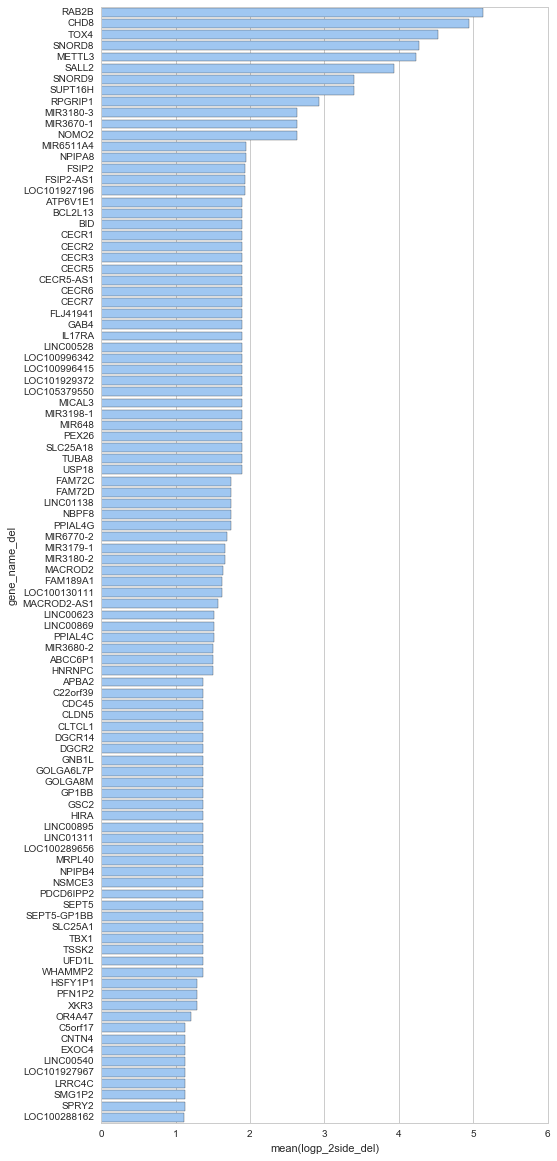

In [13]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 20))
p_df_del = pd.DataFrame({"logp_2side_del": top_logp_2side_del, "gene_name_del": top_gene_list_del})
plot_del = sns.barplot(x="logp_2side_del", y="gene_name_del", data=p_df_del, label="log pvalue 2-sided", color="b")

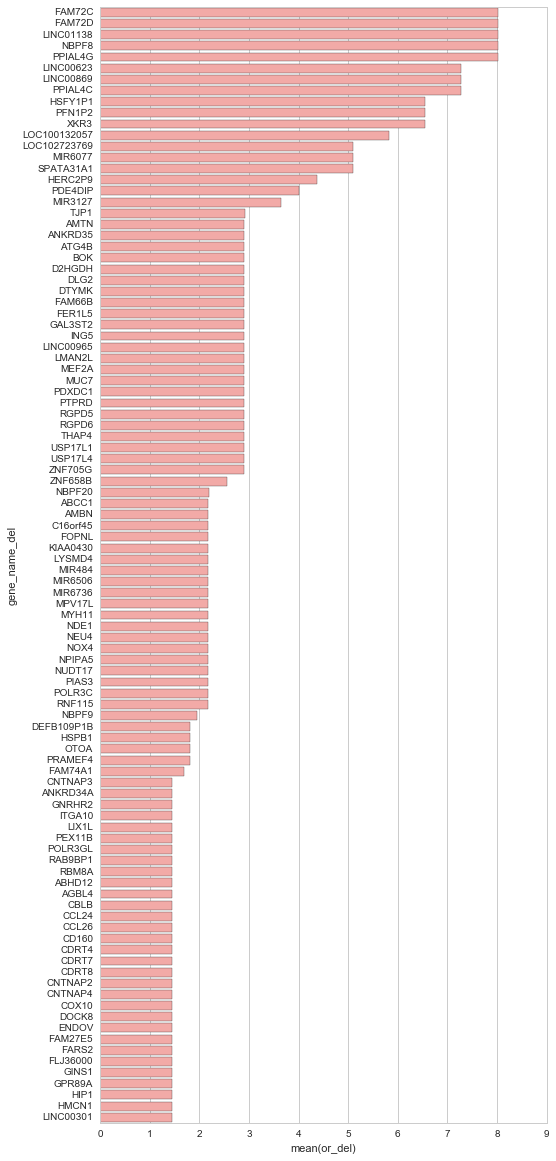

In [14]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 20))
p_df_del = pd.DataFrame({"or_del": top_or_del, "gene_name_del": top_or_gene_del})
plot_del = sns.barplot(x="or_del", y="gene_name_del", data=p_df_del, label="OR", color="r")

* Draw barplot of -log10(p_2sided) for duplication.

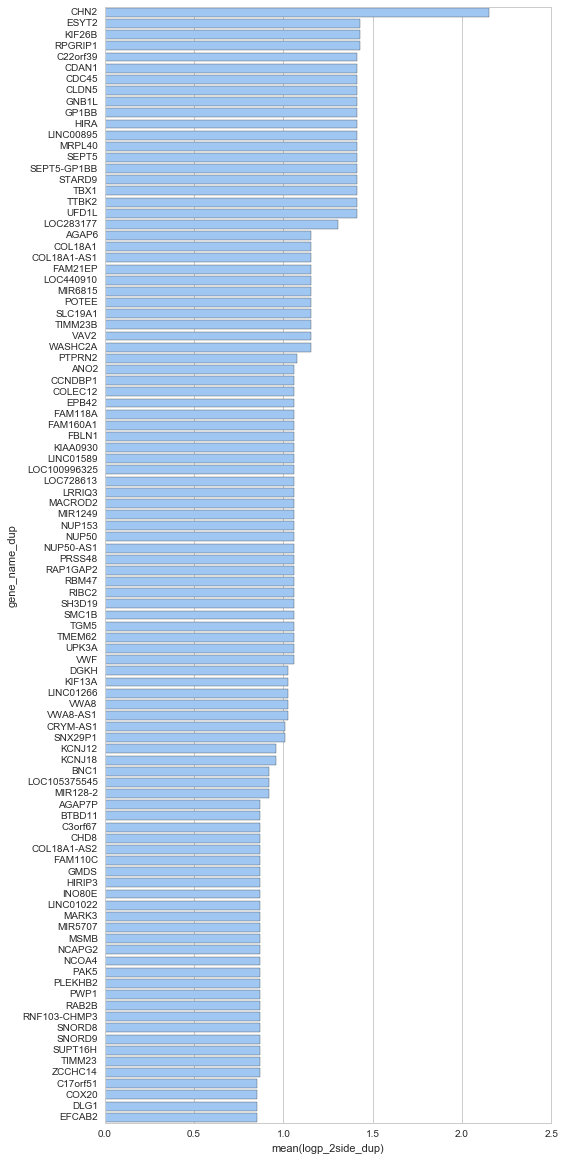

In [15]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 20))
p_df_dup = pd.DataFrame({"logp_2side_dup": top_logp_2side_dup, "gene_name_dup": top_gene_list_dup})
plot_dup = sns.barplot(x="logp_2side_dup", y="gene_name_dup", data=p_df_dup, label="log pvalue 2-sided", color="b")

In [18]:
! jupyter nbconvert --to script enrichment_analysis_of_CNV_in_schizophrenia.ipynb

[NbConvertApp] Converting notebook enrichment_analysis_of_CNV_in_schizophrenia.ipynb to script
[NbConvertApp] Writing 11744 bytes to enrichment_analysis_of_CNV_in_schizophrenia.py


## Reference
* The website for seaborn is available at [http://seaborn.pydata.org/examples/horizontal_barplot.html](http://seaborn.pydata.org/examples/horizontal_barplot.html).

* Use fast Fisher's Exact test at [https://pypi.python.org/pypi/fisher/](https://pypi.python.org/pypi/fisher/).

* Use pandas and [pandasql](https://pypi.python.org/pypi/pandasql) to transfer dictionary to DataFrame and to query pandas DataFrames using SQL syntax.